In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [4]:
# Load the training and testing data
train_path = '/content/Google_train_data.csv'
test_path = '/content/Google_test_data.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [5]:
# Exploratory Data Analysis (EDA)
def eda(data, title):
    print(f"EDA for {title} Data")
    print(data.head())
    print("\nData Info:")
    print(data.info())
    print("\nDescriptive Statistics:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Histogram of all numeric features
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data.hist(bins=30, figsize=(20, 15))
    plt.suptitle(f'Histograms of {title} Data')
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix of {title} Data')
    plt.show()

    # Pairplot for numeric features
    sns.pairplot(numeric_data)
    plt.suptitle(f'Pairplot of {title} Data')
    plt.show()

EDA for Training Data
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None

Descriptive Statistics:
              Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     15

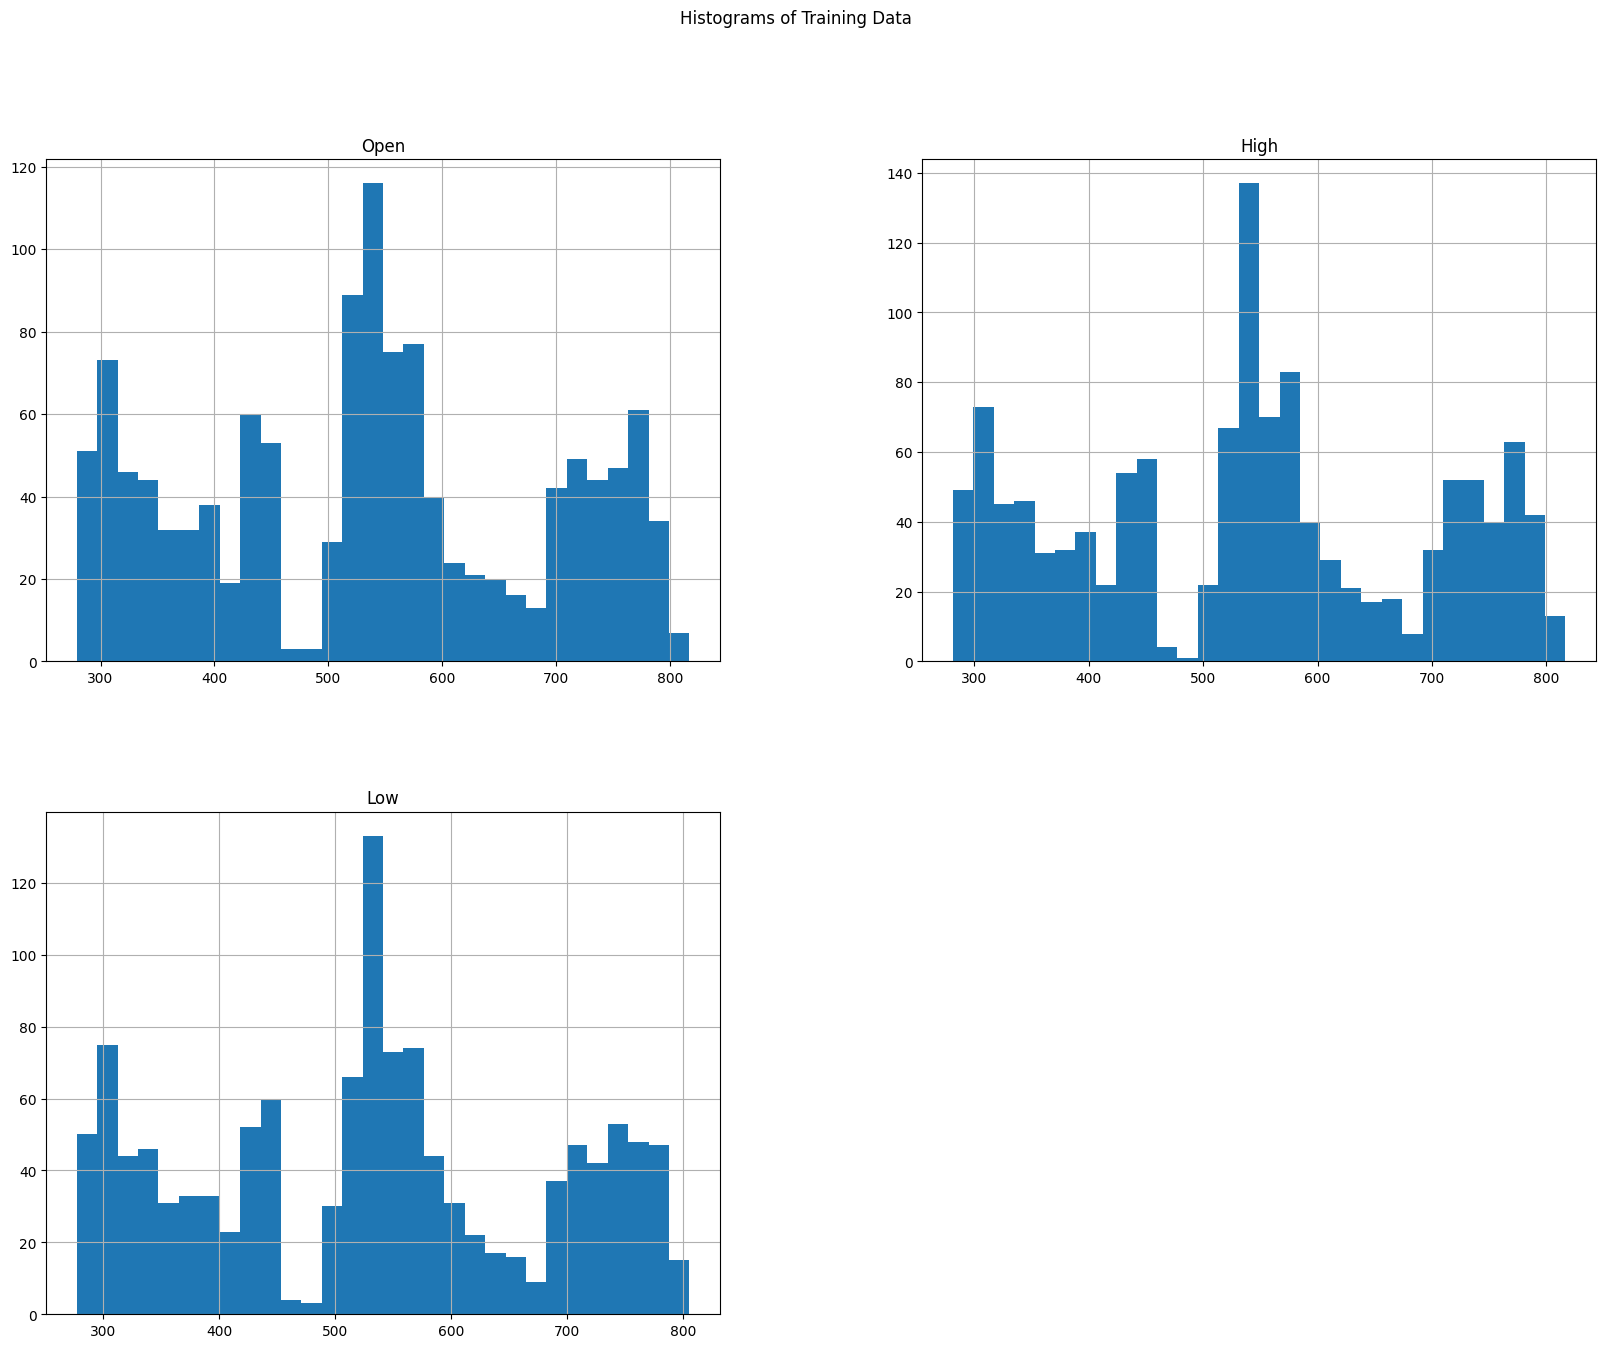

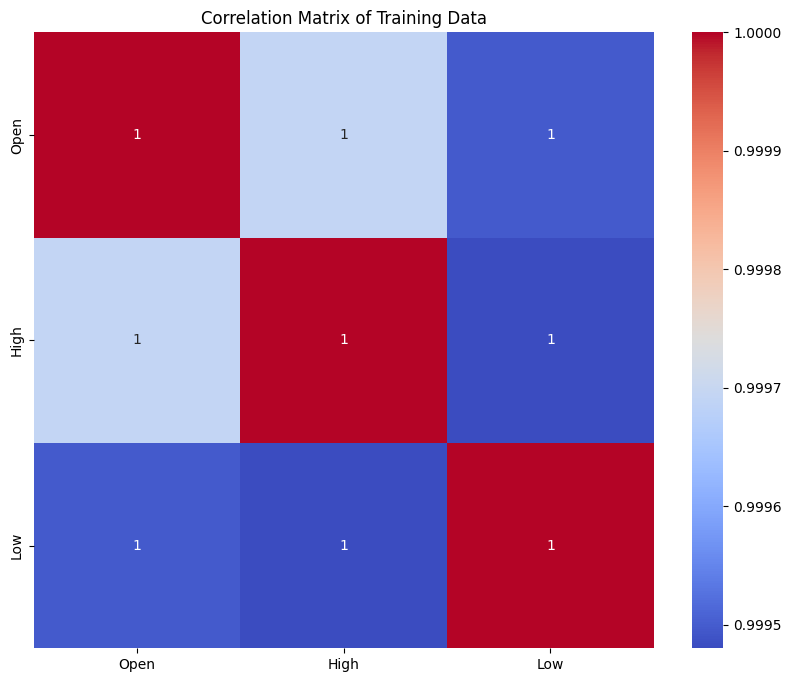

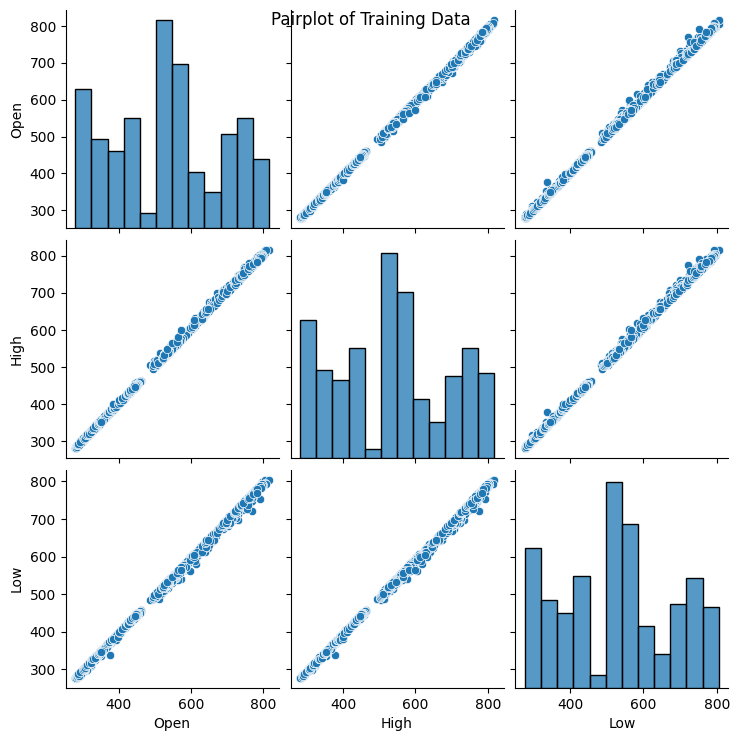

In [6]:
eda(train_data, "Training")

EDA for Testing Data
         Date         Open         High          Low        Close  \
0  2018-08-13  1236.979980  1249.272949  1233.640991  1235.010010   
1  2018-08-14  1235.189941  1245.869995  1225.109985  1242.099976   
2  2018-08-15  1229.260010  1235.239990  1209.510010  1214.380005   
3  2018-08-16  1224.729980  1226.000000  1202.550049  1206.489990   
4  2018-08-17  1202.030029  1209.020020  1188.239990  1200.959961   

     Adj Close   Volume  
0  1235.010010   997300  
1  1242.099976  1348100  
2  1214.380005  1828800  
3  1206.489990  1343200  
4  1200.959961  1389600  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Clo

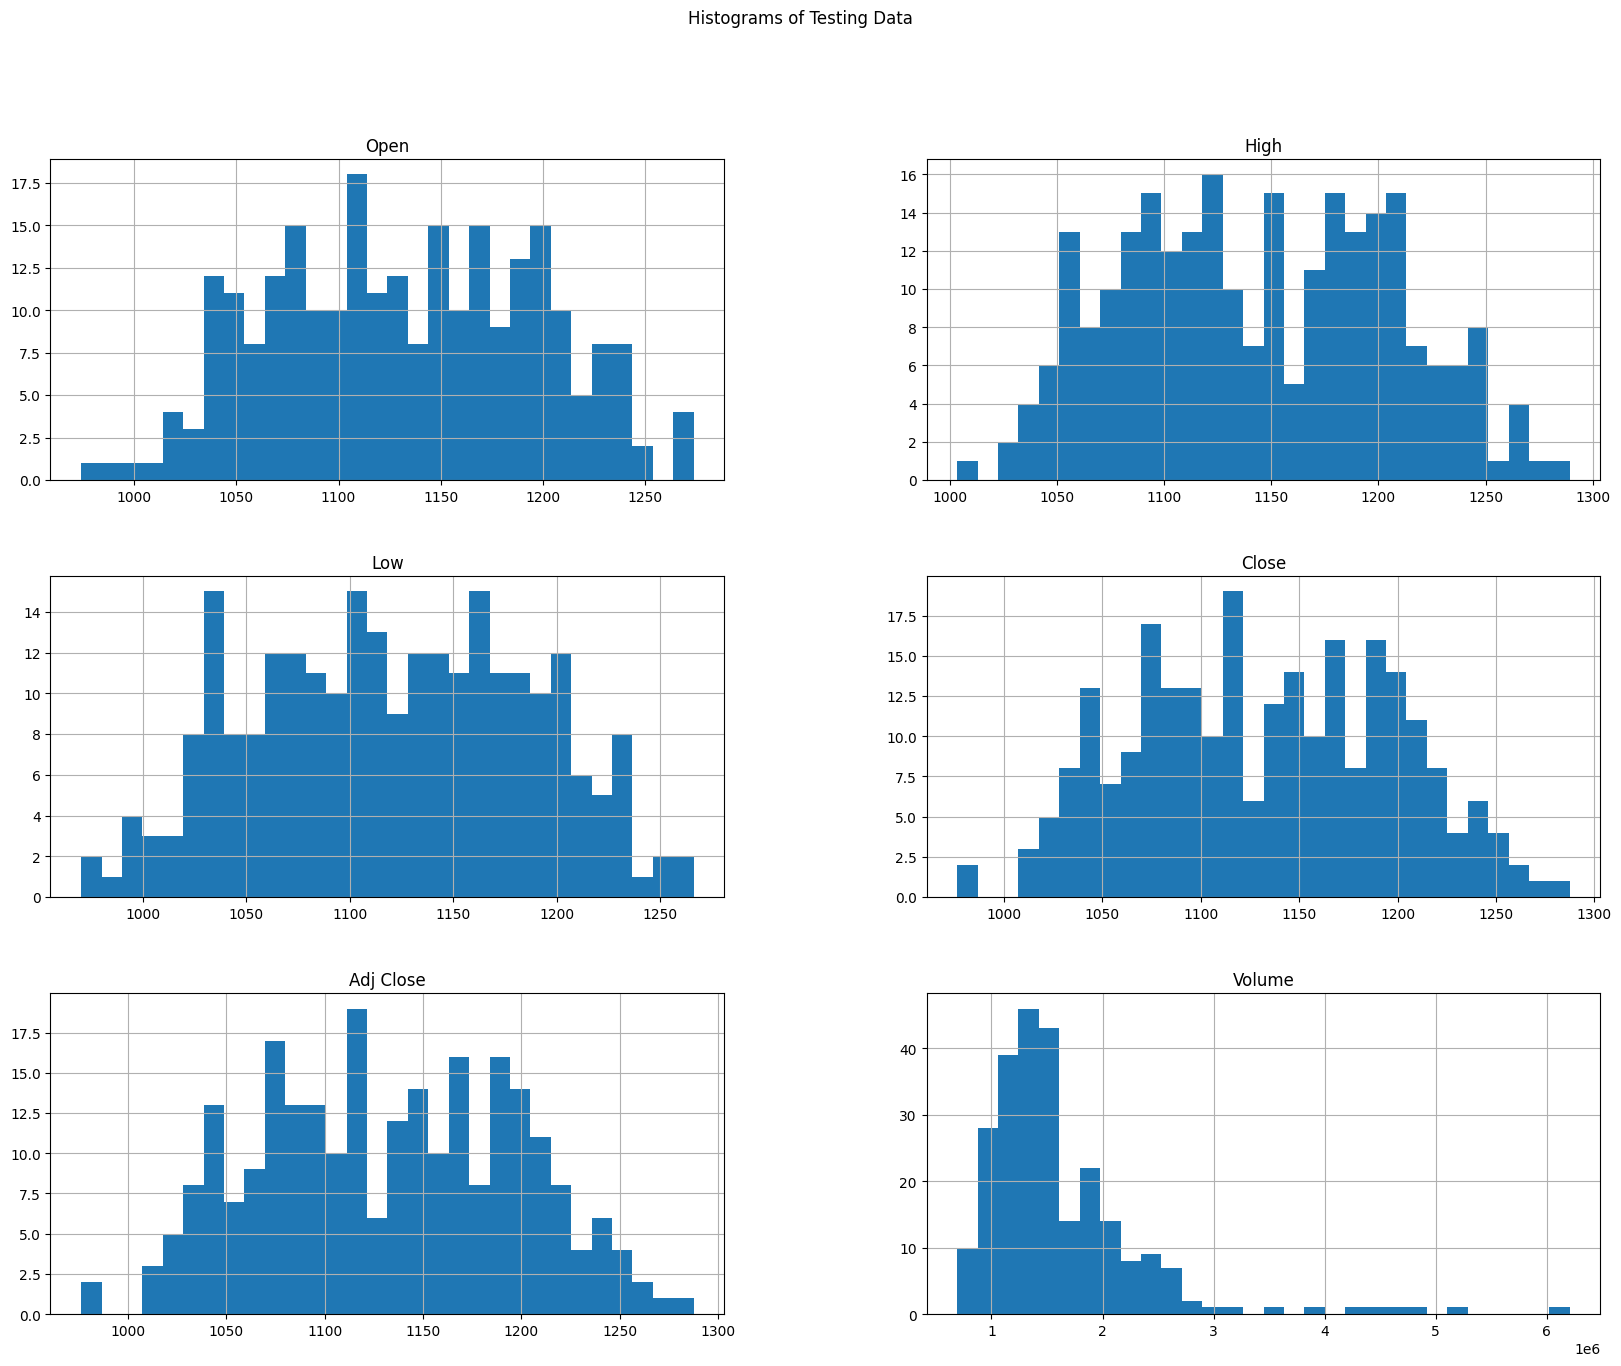

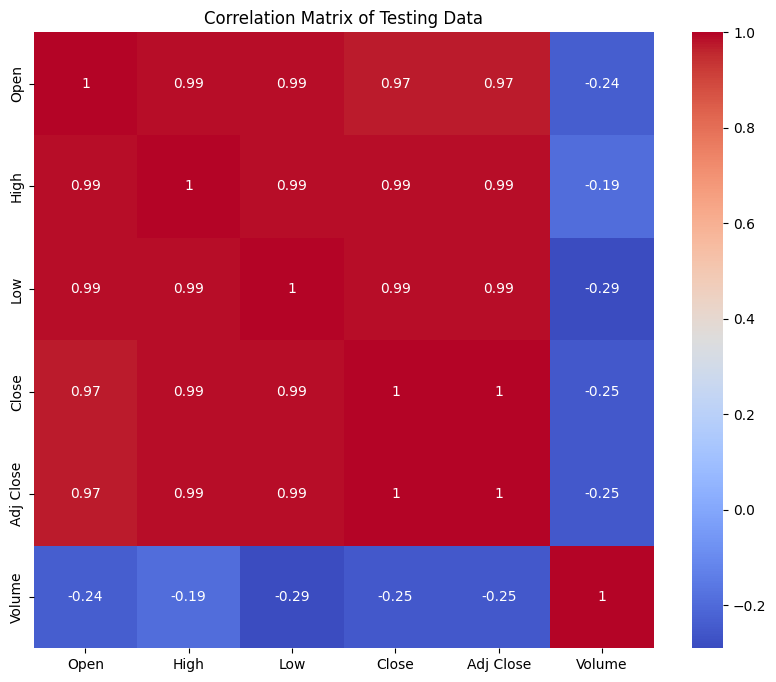

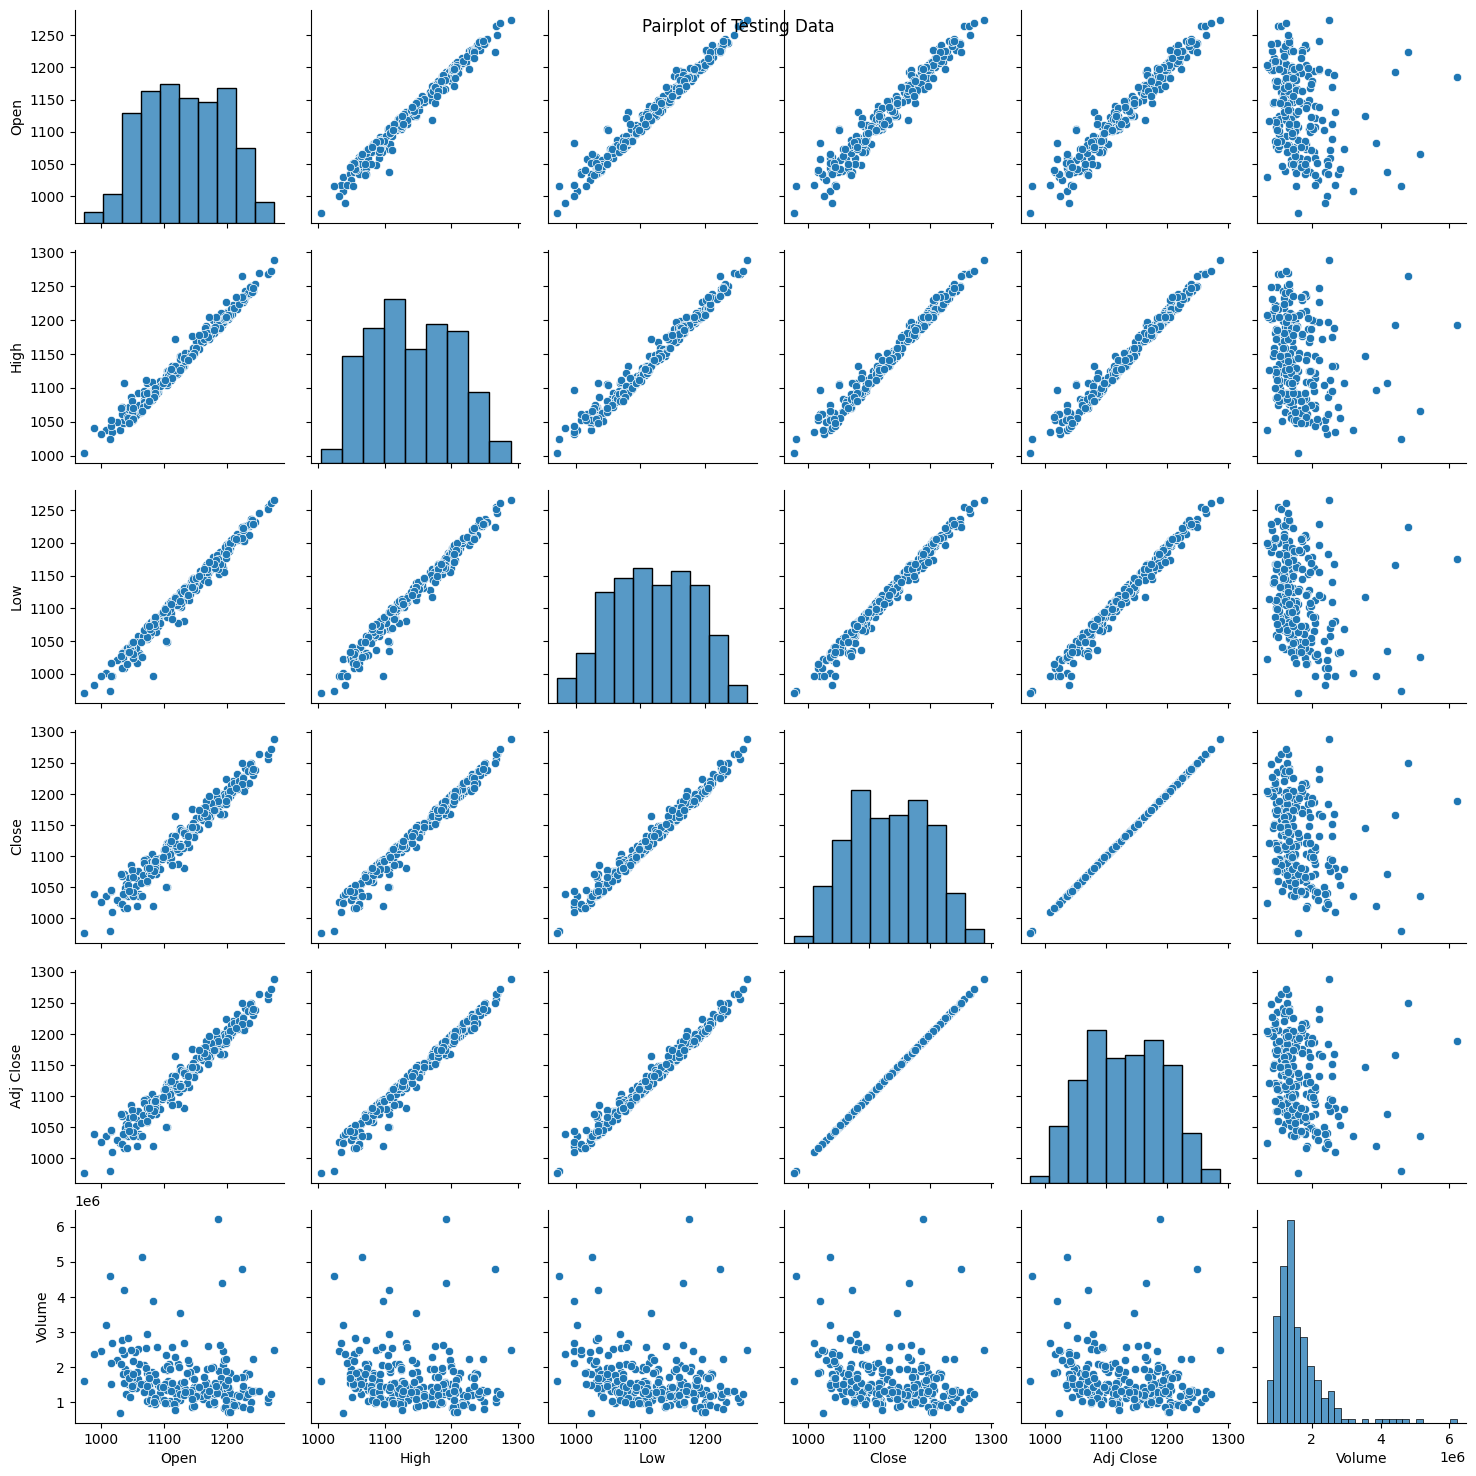

In [7]:
eda(test_data, "Testing")

In [8]:
# Function to preprocess data
def preprocess_data(data):
    # Ensure 'Volume' and 'Close' are treated as strings and then convert to numeric
    if 'Volume' in data.columns:
        data['Volume'] = data['Volume'].astype(str).str.replace(',', '')
        data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')
    if 'Close' in data.columns:
        data['Close'] = data['Close'].astype(str).str.replace(',', '')
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

    # Drop unnecessary columns if they exist
    columns_to_drop = ['Date', 'Adj Close']
    for column in columns_to_drop:
        if column in data.columns:
            data = data.drop(columns=[column])

    # Feature Engineering: Add new features
    data['High_Low_Spread'] = data['High'] - data['Low']
    data['Open_Close_Spread'] = data['Open'] - data['Close']
    data['Average_Price'] = (data['High'] + data['Low']) / 2

    return data

In [9]:
# Preprocess the data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [10]:
# Separate features and target variable in training data
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']

In [11]:
# Separate features and target variable in testing data
X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close']

In [12]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

In [14]:
# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             verbose=2)

In [15]:
# Best parameters from grid search
best_params = grid_search.best_params_
print(f'Best parameters from Grid Search: {best_params}')

Best parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


In [16]:
# Train the model with best parameters
xgb_model_best = xgb.XGBRegressor(**best_params)
xgb_model_best.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Evaluate model performance using cross-validation
cv_scores = cross_val_score(xgb_model_best, X_train_scaled, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean()}')

Cross-validation scores: [-0.56953883  0.7361236   0.97923434  0.90928651  0.80147332]
Mean CV score: 0.5713157867171098


In [18]:
# Predict on the test data
y_pred = xgb_model_best.predict(X_test_scaled)

In [19]:
# Calculate custom accuracy
def custom_accuracy(y_true, y_pred):
    return np.mean(1 - np.abs((y_true - y_pred) / y_true))

accuracy = custom_accuracy(y_test.values, y_pred)
print(f'Custom Accuracy: {accuracy:.4f}')

Custom Accuracy: 0.7154


In [20]:
# Evaluate using standard metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 324.73
Mean Squared Error (MSE): 109575.18
Root Mean Squared Error (RMSE): 331.02


In [21]:
# Function to make predictions with new input data
def predict_new(input_data):
    input_df = pd.DataFrame(input_data, index=[0])
    input_scaled = scaler.transform(input_df)
    prediction = xgb_model_best.predict(input_scaled)
    return prediction[0]

# Example input data
new_input = {
    'Open': 1500,
    'High': 1520,
    'Low': 1480,
    'Volume': 1200000,
    'High_Low_Spread': 40,  # Calculated as High - Low
    'Open_Close_Spread': 20,  # Calculated as Open - Close (example value, should be calculated correctly)
    'Average_Price': 1500  # Calculated as (High + Low) / 2
}

# Make a prediction with the new input data
predicted_close = predict_new(new_input)
print(f'Predicted Close Price: {predicted_close:.2f}')

Predicted Close Price: 802.31
